In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
import sys

import time
import torch
import torch.hub
import torch.nn

import random
import pickle

# import self-defined MB-simCLR module
from mbsimclr import MbSimCLRModel

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load data

In [3]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])

In [4]:
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")
copy_gut_16s_df = gut_16s_df.copy()
copy_gut_16s_df['SubjectID'] = [copy_gut_16s_df.index[i][0:7] for i in range(len(copy_gut_16s_df.index))]
gut_16s_df_subj = pd.merge(left=copy_gut_16s_df, right=subjects, how='left', on='SubjectID')
gut_16s_df_subj.index = copy_gut_16s_df.index

In [5]:
# Get indexes for shared patient ids
indexes = list(set(gut_16s_df.index.values) & set(metabolome_df.index.values))
indexes.sort()
print("# of samples: {}".format(len(indexes)))

# of samples: 720


## Load model and make plots

In [6]:
random_seed_list = [1]

tuning_save_folder = './save_MBsimCLR'

covariate_list = ['IR_IS_classification', 'Sex', 'Race']

dropout_list = np.arange(0.2, 1, 0.2)
weight_decay_list = 0.01*2.**np.linspace(-2,5,8)
temp_list = 0.5*2.**np.linspace(-2,2,5)

## From 1b-v - save and visualize the tuning results_random seeds_1-12
max_idx = dict(list(zip(covariate_list, [(2, 5, 1), (1, 4, 0), (0, 2, 0)])))


IR_IS_classification
n train: 382
n val: 81
n test: 84


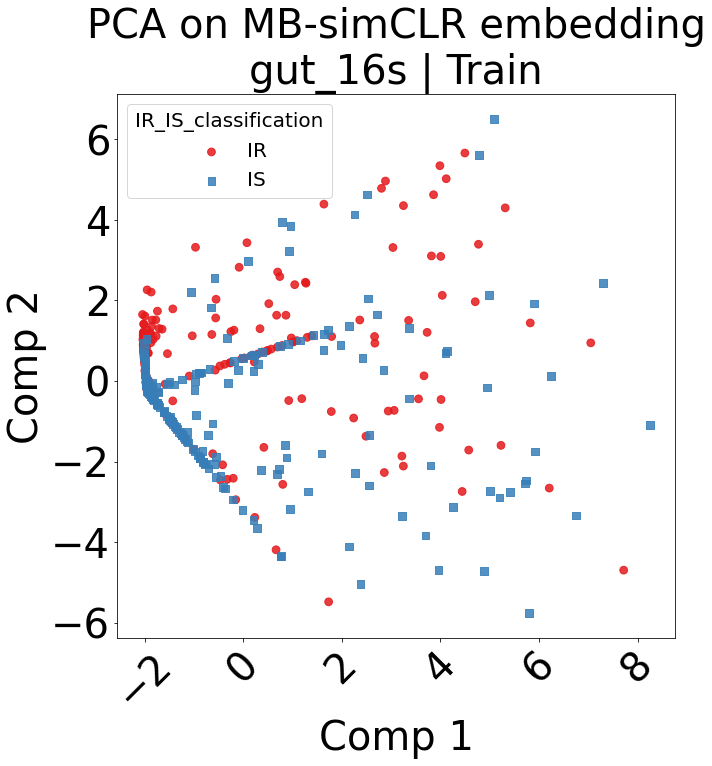

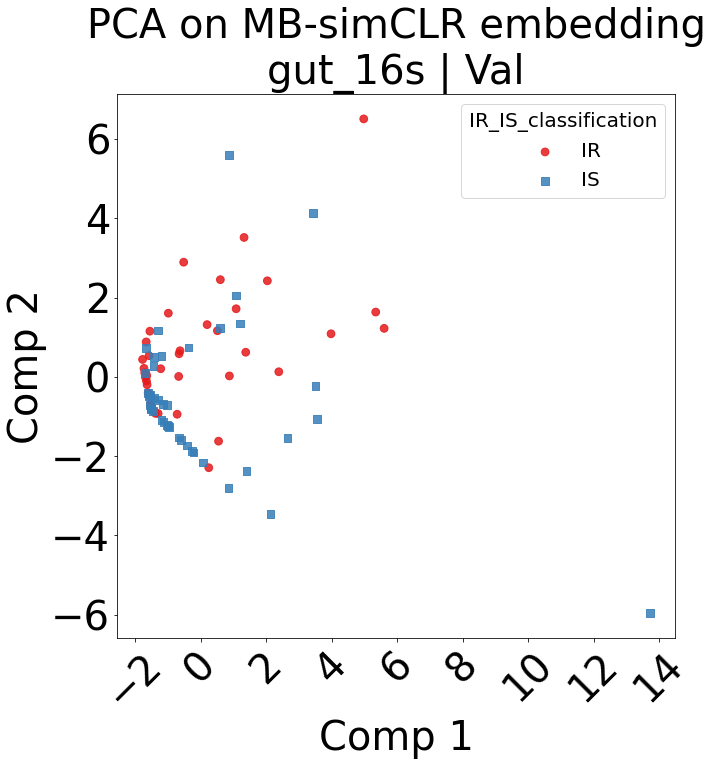

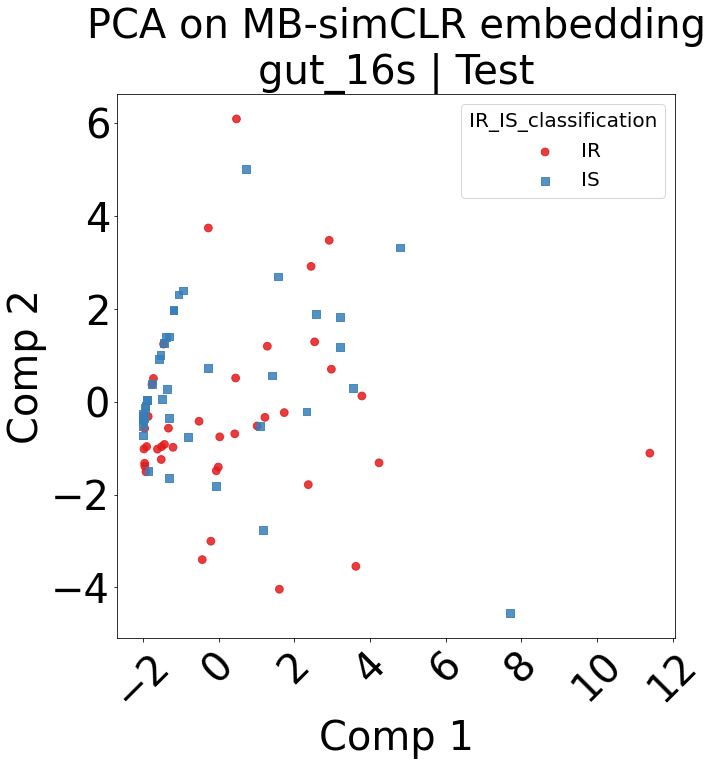

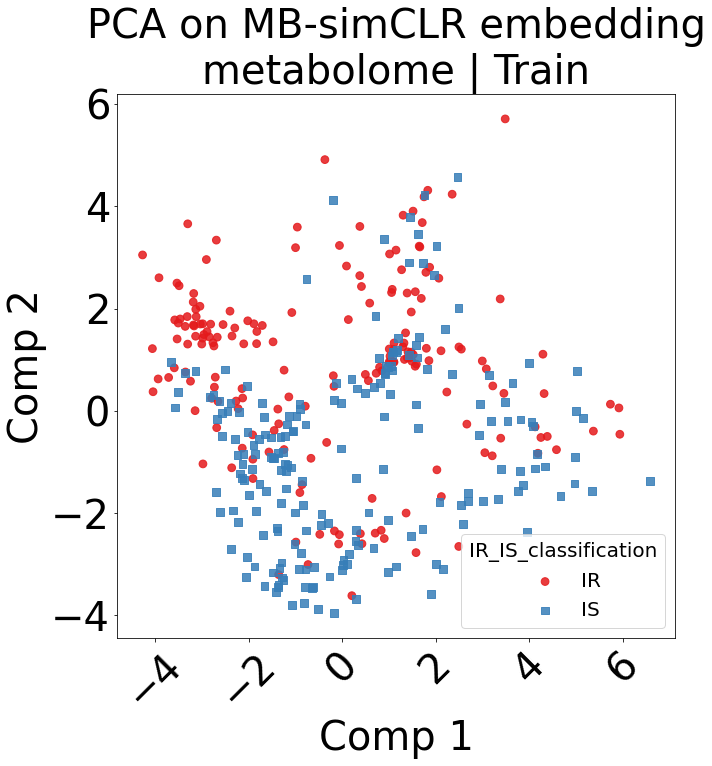

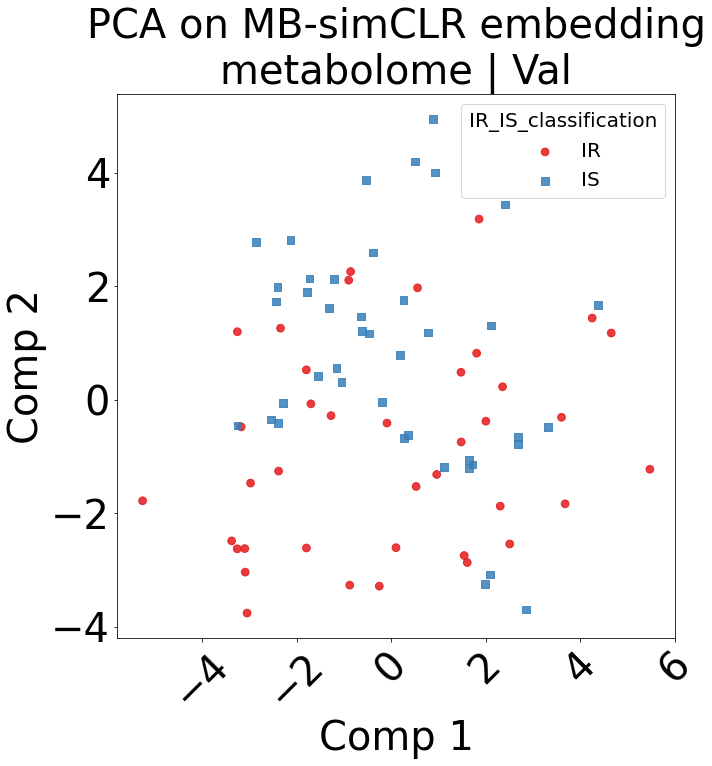

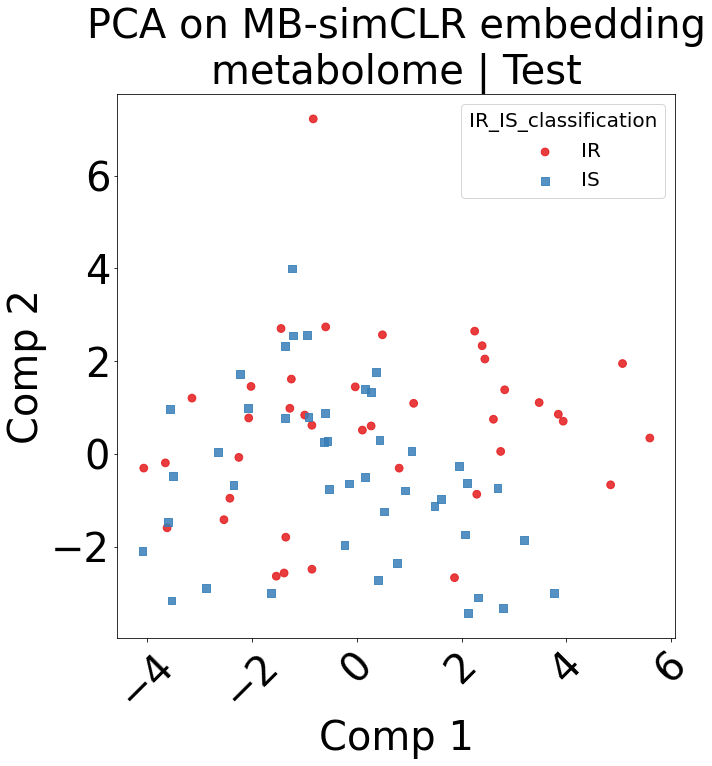


Sex
n train: 503
n val: 107
n test: 110


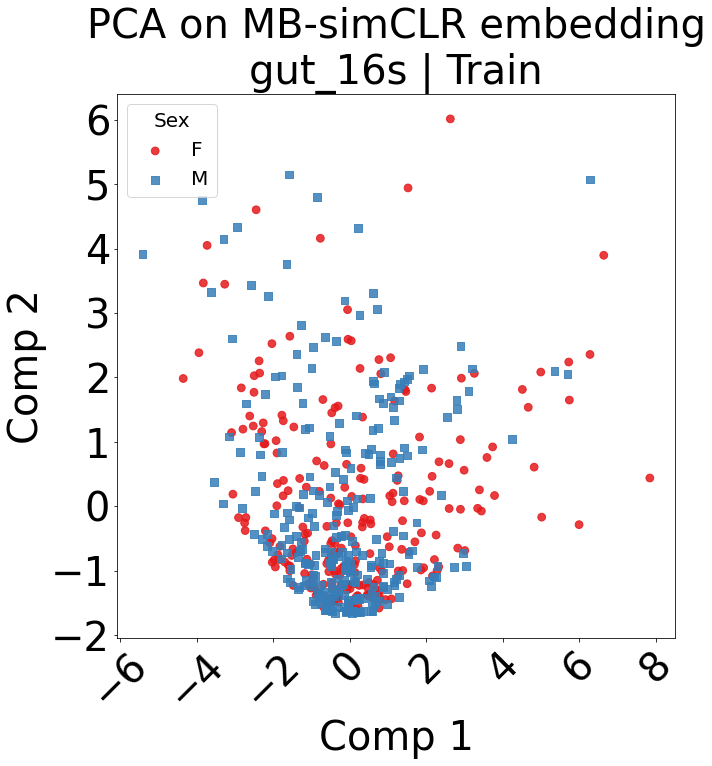

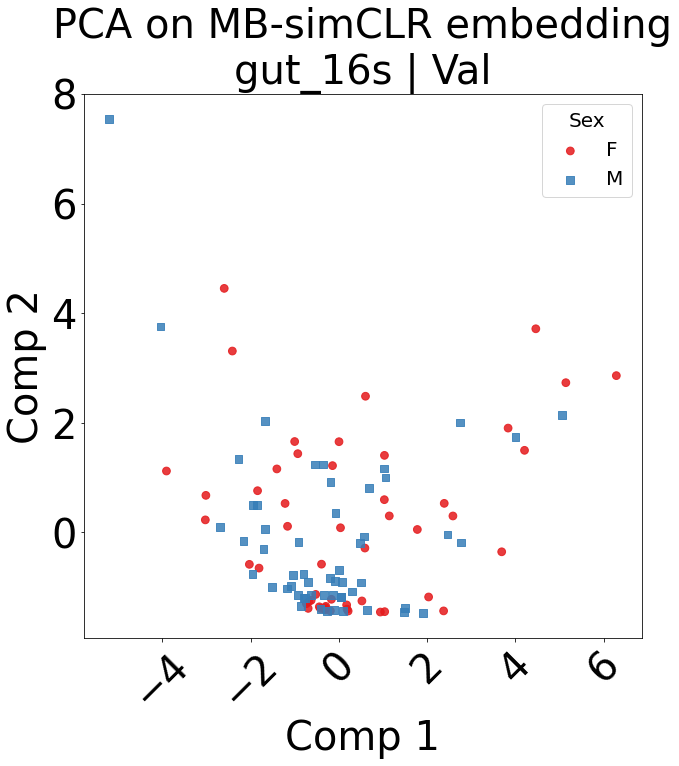

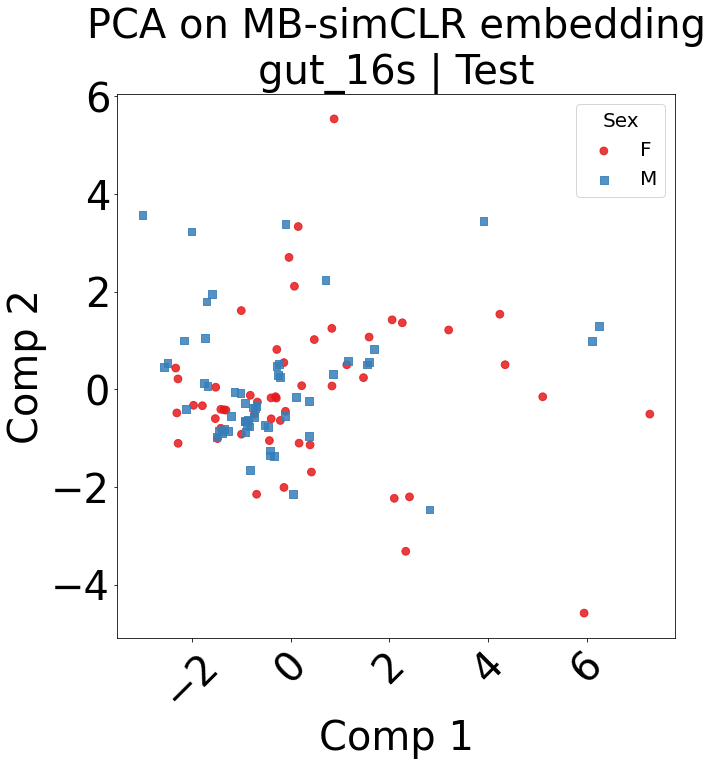

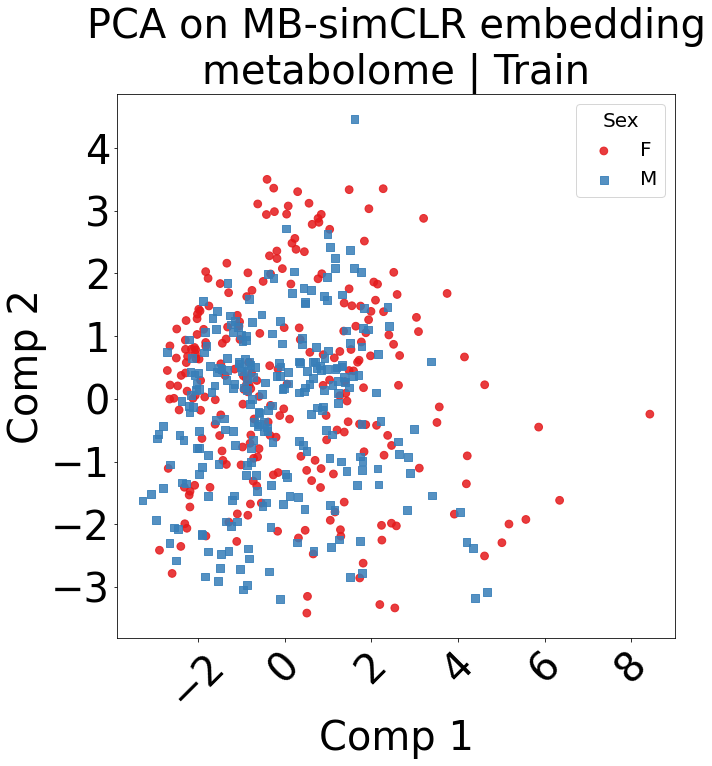

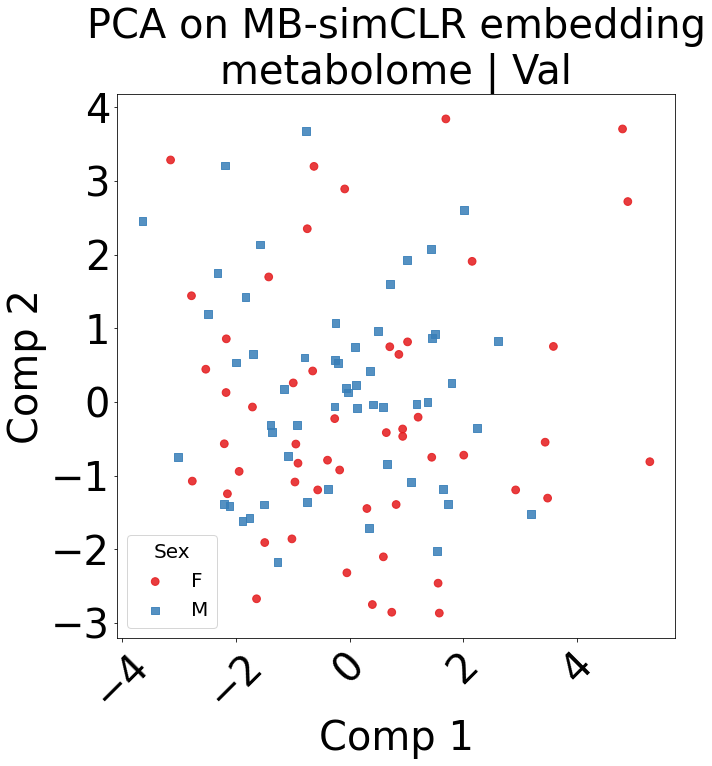

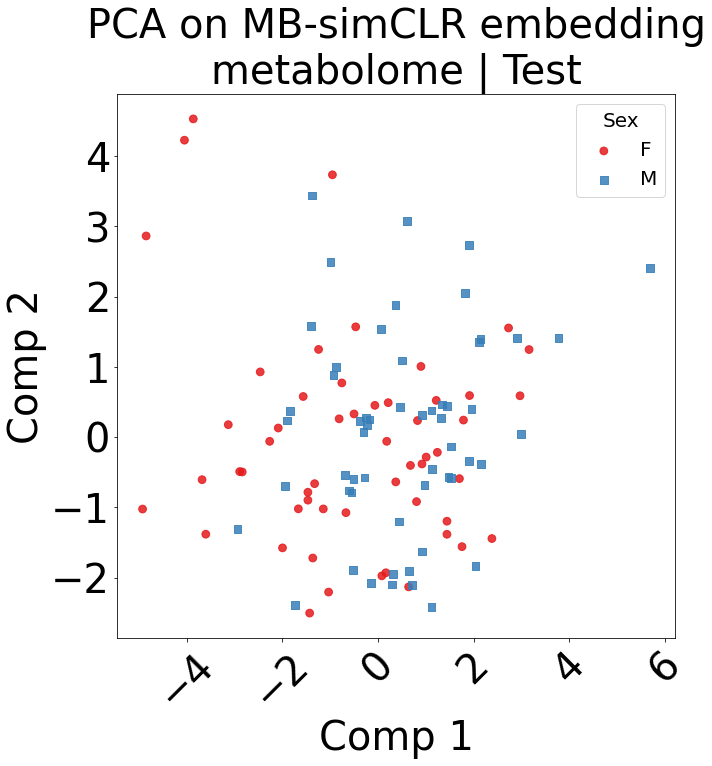


Race
n train: 501
n val: 105
n test: 112


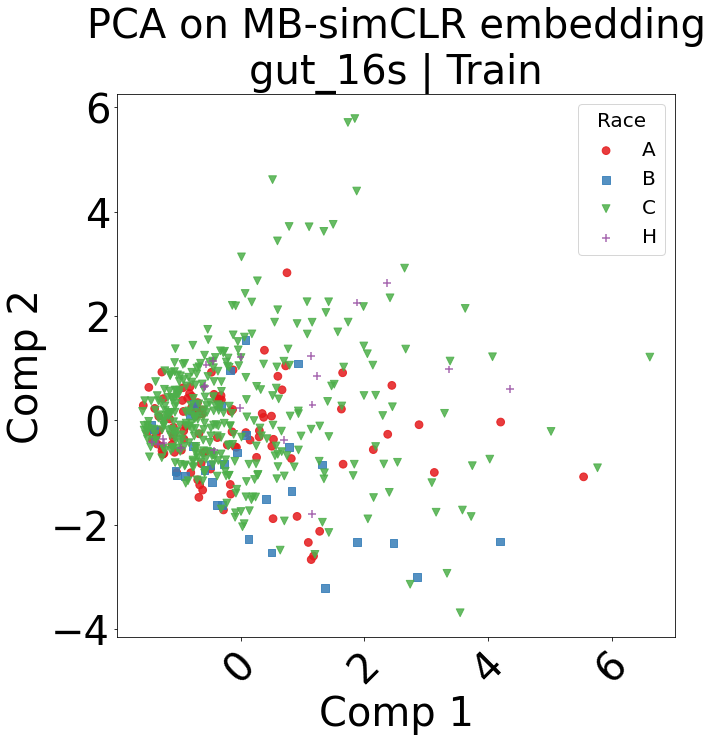

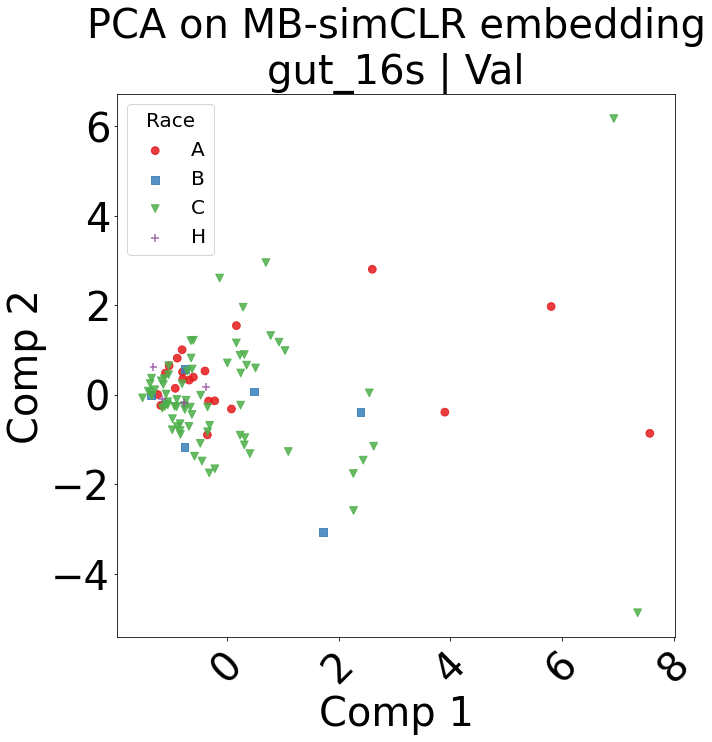

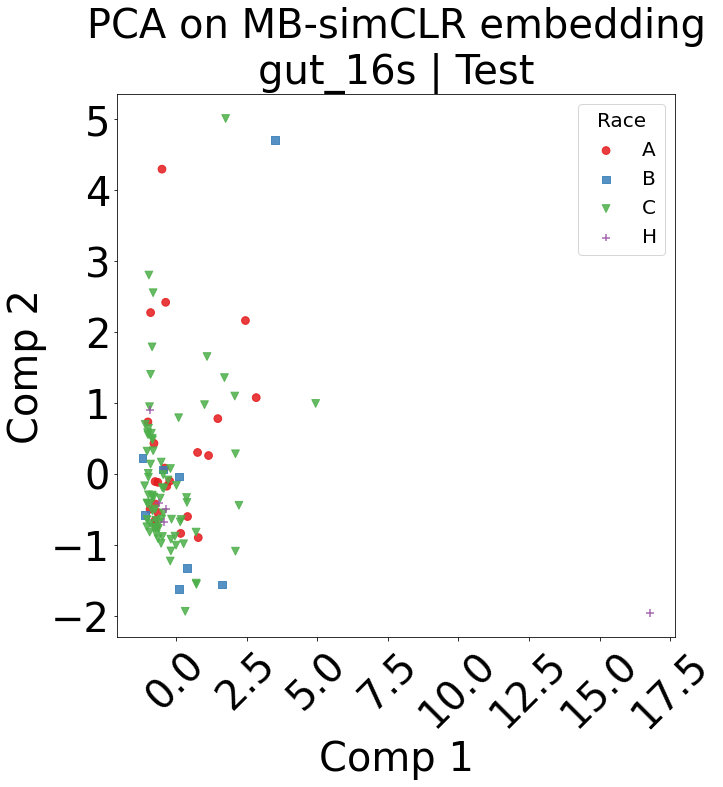

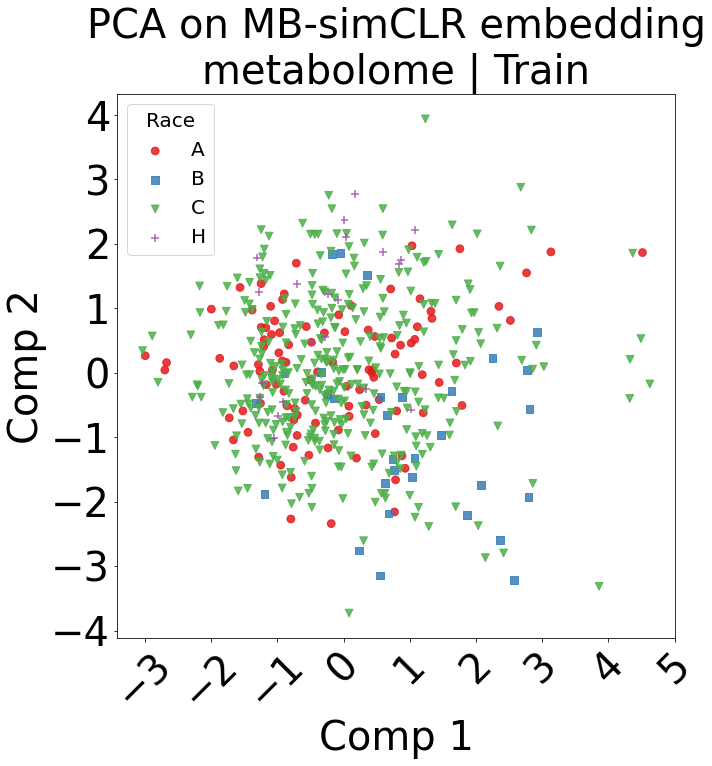

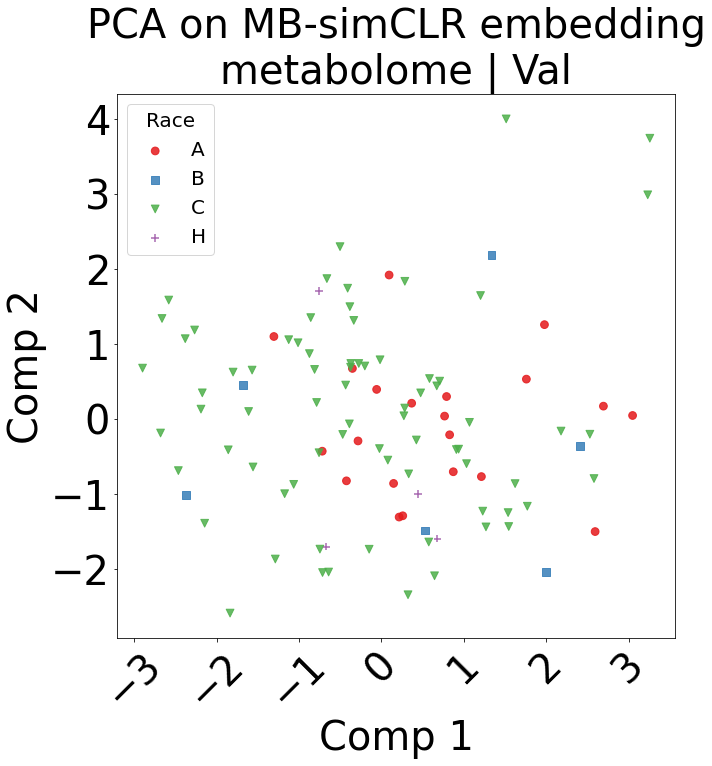

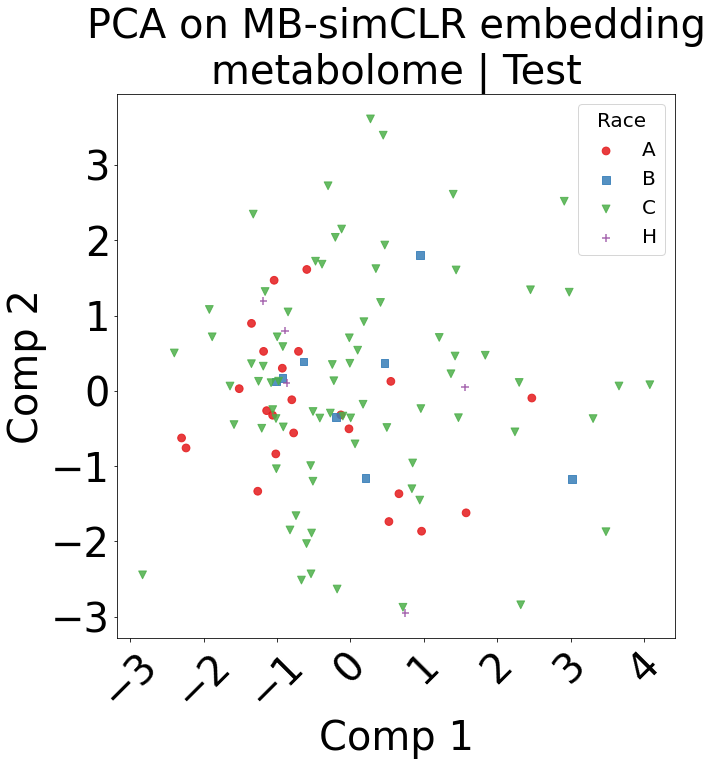

19.336663722991943
CPU times: user 46.6 s, sys: 7.78 s, total: 54.4 s
Wall time: 19.3 s


In [7]:
%%time
start_time = time.time()

N_EPOCH = 1000
DEVICE = "cuda:1"

multi_omics_dict = {'gut_16s': gut_16s_df, 'metabolome': metabolome_df}
net_dict = {"gut_16s": [gut_16s_df.shape[1], 64, 16], 
            "metabolome": [metabolome_df.shape[1], 256, 64]}
dim_reduction_list = ['pca']

for covariate in covariate_list:
    dropout = dropout_list[max_idx[covariate][0]]
    weight_decay = weight_decay_list[max_idx[covariate][1]]
    temperature = temp_list[max_idx[covariate][2]]

    for s, seed in enumerate(random_seed_list):
        ### load models, not necessary to train them again
        model_save_folder = os.path.join(tuning_save_folder, 'models/{}'.format(covariate))
        model_path = os.path.join(model_save_folder, 
                                  'MB-simCLR_{}_epoch-{}_temp-{}_dropout-{}_SGD-wd-{}_seed-{}.pth'.\
                         format(covariate, N_EPOCH, temperature, dropout, weight_decay, seed))
        
        embedding_save_folder = os.path.join(tuning_save_folder, 'embeddings/{}'.format(covariate))
        embedding_path = os.path.join(embedding_save_folder, 
                                      'embeddings_{}_epoch-{}_temp-{}_dropout-{}_SGD-wd-{}_seed-{}.pkl').\
              format(covariate, N_EPOCH, temperature, dropout, weight_decay, seed)
        
        
        MB_simCLR = MbSimCLRModel(covariate=covariate, indexes=indexes, multi_omics_dict=multi_omics_dict,
                                 df_with_covariates=gut_16s_df_subj, device=DEVICE,
                                 root_folder=tuning_save_folder, random_seed=seed)
        MB_simCLR.initialize(net_dict=net_dict, 
                             temperature=temperature, dropout_rate=dropout, weight_decay=weight_decay)
        MB_simCLR.load_model(model_path, embedding_path)
        
        for dim_reduction in dim_reduction_list:
            MB_simCLR.dim_reduction_embedding(dim_reduction_method = dim_reduction, fontsize=40)
            
end_time = time.time()
print(end_time - start_time)